In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
import re
import os
import cv2
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from scipy.interpolate import UnivariateSpline
from scipy.spatial import ConvexHull
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
%cd /scratch/user/anshulya
%ls

/scratch/user/anshulya
134/       318.csv                          hls_job4.sh
134.csv    343/                             in-situ_data.csv
158/       343.csv                          jrc_data/
158.csv    343_f.csv                        jupyter_notebooks/
167/       383_LAKE_MEAD.tif                lake_rf_new.pkl
167.csv    800_res.geojson                  lake_rf_new_L30.pkl
167_f.csv  DAACDataDownload.py              log_files/
176/       LAKE_MEAD_dem.tif                max_img_extent.csv
176.csv    PIP_CACHE/                       ondemand/
176_f.csv  WT_432.geojson                   ondemand-faster/
20/        area_estimation_driver.sh*       opera_data/
212/       area_job1.sh                     script_134_area.sh
212.csv    clipped_data_creation.py         script_158_area.sh
212_f.csv  clipped_raster.tif               script_167_area.sh
269/       data_download_driver.sh*         script_176_area.sh
269.csv    estimate_area.py                 script_212_area.sh
269_f.csv  esti

In [3]:
!ls

134	   318.csv			    hls_job4.sh
134.csv    343				    in-situ_data.csv
158	   343.csv			    jrc_data
158.csv    343_f.csv			    jupyter_notebooks
167	   383_LAKE_MEAD.tif		    lake_rf_new.pkl
167.csv    800_res.geojson		    lake_rf_new_L30.pkl
167_f.csv  DAACDataDownload.py		    log_files
176	   LAKE_MEAD_dem.tif		    max_img_extent.csv
176.csv    PIP_CACHE			    ondemand
176_f.csv  WT_432.geojson		    ondemand-faster
20	   area_estimation_driver.sh	    opera_data
212	   area_job1.sh			    script_134_area.sh
212.csv    clipped_data_creation.py	    script_158_area.sh
212_f.csv  clipped_raster.tif		    script_167_area.sh
269	   data_download_driver.sh	    script_176_area.sh
269.csv    estimate_area.py		    script_212_area.sh
269_f.csv  estimate_area_canny.py	    script_269_area.sh
271	   estimate_area_canny_parallel.py  script_271_area.sh
271.csv    frequency.png		    script_294_area.sh
294	   hls_data			    script_318_area.sh
294.csv    hls_job1.sh			    script_343_area.sh
294_f.csv  h

In [4]:
def preprocess_reservoir_shp(fname):
  reservoirs = gp.read_file(fname)

  reservoirs.loc[107,'name'] = 'Farmer_s Creek Reservoir'

  t = ['/' in s for s in reservoirs['name']]
  i = 0
  res_names = ['Cox Lake', 'Eagle Nest Lake_Manor Lake', 'Lake Ballinger_Lake Moonen', 'Lake Olney_Lake Cooper', 'Mustang Lake']
  for res_idx in [77, 93, 183, 250, 315]:
    reservoirs.loc[res_idx, 'name'] = res_names[i]
    i = i + 1

  i = 0
  res_names = ['Lake Gonzales','Clear Lake Wa']
  for res_idx in [218, 70]:
    reservoirs.loc[res_idx, 'name'] = res_names[i]
    i = i + 1

  for i in range(812):
    string = reservoirs.loc[i, 'name']
    regex = re.compile('[@!#$%^&*()<>?/\|}{~]')
    # Pass the string in search
    # method of regex object.
    if(regex.search(string) == None):
      continue
    else:
      print(i,string)

  return reservoirs

In [5]:
## Get reservoir shapefile and geometry
fname = '800_res.geojson'
reservoirs = preprocess_reservoir_shp(fname)
for idx, row in reservoirs.iterrows():
    lat = row['geometry'].centroid.y
    area = row['geometry'].area*111*111*np.cos(lat/180*np.pi)
    reservoirs.loc[idx,'area'] = area

In [11]:
res_idx = 271
if pd.isna(reservoirs.loc[res_idx,'grand_id']) or reservoirs.loc[res_idx,'grand_id']==-999:
    im_name = str(0) + '_' + reservoirs.loc[res_idx,'name'].replace(" ", "_")
else:
    im_name = str(int(reservoirs.loc[res_idx,'grand_id'])) + '_' + reservoirs.loc[res_idx,'name'].replace(" ", "_")

In [12]:
print(reservoirs.loc[res_idx,'name'])

Lake Tschida


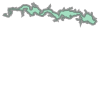

In [13]:
reservoirs.loc[res_idx,'geometry']

In [14]:
cls_df = pd.read_csv(str(res_idx)+'.csv')
cls_df = cls_df[(cls_df['enh_area1']>0)&(cls_df['enh_area1']<900)]
cls_df = cls_df[(cls_df['cloud_cover']<100)&(cls_df['cloud_cover']>=0)]
cls_df['datetime'] = pd.to_datetime(cls_df['date'],format='%Y%j')
cls_df = cls_df.sort_values(by='date')
cls_df

,date,terrain_area,enh_area1,enh_area2,threshold,elbow,cloud_cover,datetime
315,2016008,1.5174,8.8344,11.0871,91.0,66.0,21.712353,2016-01-08
346,2016038,0.9855,8.6409,9.6822,92.0,87.0,22.621188,2016-02-07
546,2016054,0.0531,0.0531,0.0531,NaN,NaN,0.182848,2016-02-23
509,2016070,5.3460,10.2465,11.0421,87.0,76.0,13.517219,2016-03-10
593,2016086,11.5812,11.5812,11.5812,NaN,NaN,1.769016,2016-03-26
...,...,...,...,...,...,...,...,...
136,2023281,11.7945,11.7945,11.7945,NaN,NaN,2.513178,2023-10-08
288,2023283,10.7604,10.7604,10.7604,NaN,NaN,1.703739,2023-10-10
69,2023288,7.2351,10.0098,11.2176,93.0,79.0,8.075601,2023-10-15
581,2023289,11.1834,11.1834,11.1834,NaN,NaN,2.196583,2023-10-16


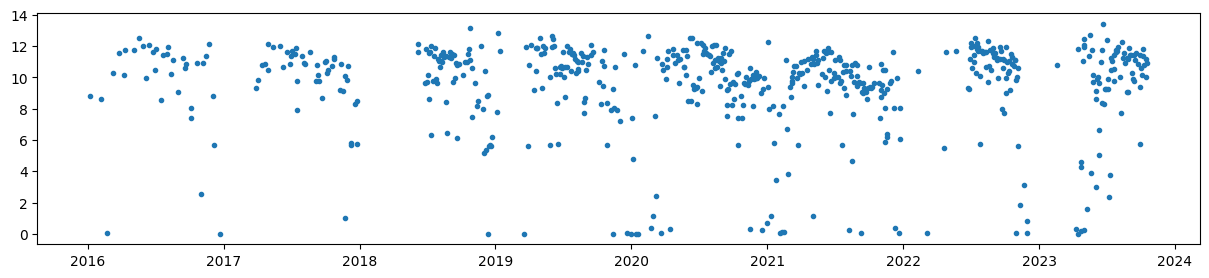

In [15]:
plt.figure(figsize=(15,3))
plt.plot(cls_df['datetime'],cls_df['enh_area1'],'.')
plt.show()

In [16]:
# def find_elbow(data):
#     """
#     Find the elbow point in a dataset.
    
#     Parameters:
#     - data: A list or numpy array of y-values.
    
#     Returns:
#     - index of the elbow point.
#     """
#     # Create a vector from the first data point to the last data point
#     first_point = [0, data[0]]
#     last_point = [len(data) - 1, data[-1]]
#     line_vector = np.subtract(last_point, first_point)
    
#     # Normalize the line vector
#     line_vector_norm = line_vector / np.sqrt(sum(line_vector**2))
    
#     # Find the point that is farthest from the line
#     max_distance = -1
#     elbow_index = 0
#     for i, value in enumerate(data):
#         point = [i, value]
#         distance = np.abs(np.cross(line_vector_norm, np.subtract(first_point, point)))
#         if distance > max_distance:
#             max_distance = distance
#             elbow_index = i
            
#     return elbow_index

In [17]:
# or_jrc_data = rio.open(os.path.join('jrc_data',im_name+'.tif')).read(1).astype('float')
# for idx, row in cls_df.iterrows():
    
#     print(str(row['date']))
    
#     raw = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date']),'terrain.npy'))
#     enh = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date']),'enhanced.npy'))
    
# #     if raw.shape[0]<1945*0.9 or raw.shape[1]<3229*0.9:
# #         print('Half image')
# #         continue
    
#     # Input the JRC data
#     jrc = rio.open(os.path.join(str(res_idx),'clipped_rasters',str(row['date']),'S30','jrc.tif'))
#     jrc_data = jrc.read(1)
#     print('Shape of the JRC image is {}'.format(jrc_data.shape))
    
#     X = np.load(os.path.join(str(res_idx),'classified_rasters',str(row['date']),'terrain.npy'))
    
#     if row['cloud_cover']<1:
#         print('No enhancement performed!!')
# #         fig, ax = plt.subplots(1,2, figsize=(7,10))
# #         ax[0].imshow(raw)
# #         ax[1].imshow(enh)
# #         plt.show()
#         print('Area: ',row['enh_area'])
#         cls_df.loc[idx,'enh_area1'] = cls_df.loc[idx,'enh_area']
#     else:

#         print('Carrying out enhancement!!')

#         a = 0
#         b = 30
#         Y = np.zeros(X.shape)
#         Y[X==1] = b
#         Y[X==0] = a
#         Y[X==2] = 100
#         # Create a mask for vertical transitions between a and b
#         vertical_mask = np.where(((Y == a) & (np.roll(Y, shift=-1, axis=1) == b)) |
#                                 ((Y == b) & (np.roll(Y, shift=-1, axis=1) == a)), 255, 0).astype(np.uint8)

#         # Create a mask for horizontal transitions between a and b
#         horizontal_mask = np.where(((Y == a) & (np.roll(Y, shift=-1, axis=0) == b)) |
#                                   ((Y == b) & (np.roll(Y, shift=-1, axis=0) == a)), 255, 0).astype(np.uint8)

#         # Combine the masks
#         combined_mask = np.maximum(vertical_mask, horizontal_mask)
#     #     plt.imshow(combined_mask)
#     #     plt.show()

#         # Apply Canny edge detection
#         edges = cv2.Canny(combined_mask.astype(np.uint8), 20, 40)

#     #     plt.imshow(edges, cmap='gray')
#     #     plt.show()

#         # Compute the histogram
#         hist, bins = np.histogram(jrc_data[(edges>0)&(X!=0)].flatten(), bins=100, density=True)

#         # Compute the CDF
#         cdf = np.cumsum(hist) * (bins[1] - bins[0])  # Multiply by bin width to ensure the CDF goes to 1

#         # Plot the histogram and CDF
#         plt.figure(figsize=(7, 3))

#         plt.subplot(1, 2, 1)
#         plt.bar(bins[:-1], hist, width=bins[1] - bins[0])
#         plt.title('Histogram (PDF)')

#         plt.subplot(1, 2, 2)
#         plt.plot(bins[:-1], cdf, marker='o')
#         plt.title('CDF')
#         plt.axhline(y=0.8,color='red')
#         plt.axvline(x=find_elbow(cdf),color='green')
#         plt.ylim(0, 1)

#         plt.tight_layout()
#         plt.show()



#         # Find the bin value corresponding to the first CDF value just greater than 0.9
#         index = np.where(cdf > 0.8)[0][0]
#         bin_value = bins[index]

#         print(f"The bin value corresponding to the first CDF value just greater than 0.8 is: {bin_value}")
#         print('Elbow index: ',find_elbow(cdf))
        
#         elbow_point = find_elbow(cdf)
        
#         # Compute the rate of change
#         rate_of_change = np.diff(cdf)
        
#         # Calculate average rate of change before and after the elbow point
#         avg_rate_before = np.mean(rate_of_change[:elbow_point])
#         avg_rate_after = np.mean(rate_of_change[elbow_point:])

#         # Generate the "hockeyness" index
#         hockeyness_index = avg_rate_after - avg_rate_before

#         print(f"Hockeyness Index: {hockeyness_index}")
        
#         if hockeyness_index >0.0:
#             bin_value = find_elbow(cdf)

#         X[(jrc_data>=int(bin_value))] = 1
#         enh_area = X[X==1].shape[0]*900/10**6
#         print('Area after CDF enhancement is {} km2'.format(row['enh_area']))
#         print('Area after elbow enhancement is {} km2'.format(X[X==1].shape[0]*900/10**6))
#         cls_df.loc[idx,'enh_area1'] = enh_area
    
    
# #     cls_df.loc[idx,'enh_area2'] = or_jrc_data[or_jrc_data>=bin_value].shape[0]*900/10**6
    
#     fig, ax = plt.subplots(1,3, figsize=(10,10))
#     ax[0].imshow(raw)
#     ax[1].imshow(enh)
#     ax[2].imshow(X)
#     plt.show()
#     print('-----------------------------')

In [18]:
cls_df

,date,terrain_area,enh_area1,enh_area2,threshold,elbow,cloud_cover,datetime
315,2016008,1.5174,8.8344,11.0871,91.0,66.0,21.712353,2016-01-08
346,2016038,0.9855,8.6409,9.6822,92.0,87.0,22.621188,2016-02-07
546,2016054,0.0531,0.0531,0.0531,NaN,NaN,0.182848,2016-02-23
509,2016070,5.3460,10.2465,11.0421,87.0,76.0,13.517219,2016-03-10
593,2016086,11.5812,11.5812,11.5812,NaN,NaN,1.769016,2016-03-26
...,...,...,...,...,...,...,...,...
136,2023281,11.7945,11.7945,11.7945,NaN,NaN,2.513178,2023-10-08
288,2023283,10.7604,10.7604,10.7604,NaN,NaN,1.703739,2023-10-10
69,2023288,7.2351,10.0098,11.2176,93.0,79.0,8.075601,2023-10-15
581,2023289,11.1834,11.1834,11.1834,NaN,NaN,2.196583,2023-10-16


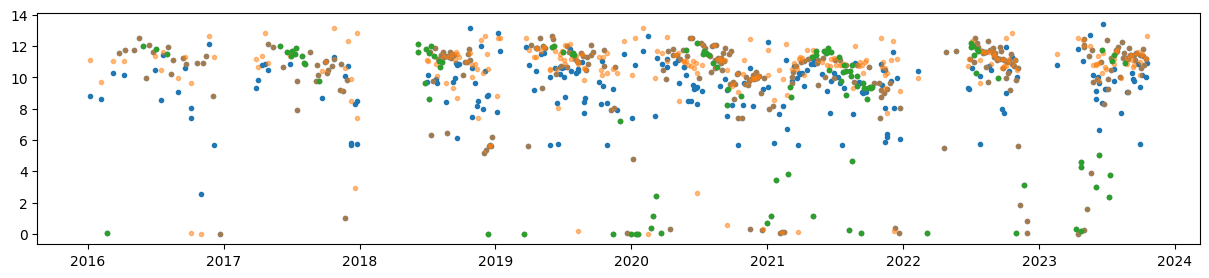

In [19]:
df_ = cls_df[(cls_df['cloud_cover']<1)&(cls_df['enh_area1']>0)]
df2 = cls_df[(cls_df['enh_area1']<100)&(cls_df['enh_area1']>0)]

plt.figure(figsize=(15,3))
plt.plot(df2['datetime'],df2['enh_area1'],'.')
plt.plot(df2['datetime'],df2['enh_area2'],'.',alpha=0.5)
plt.plot(df_['datetime'],df_['enh_area1'],'.')
plt.show()

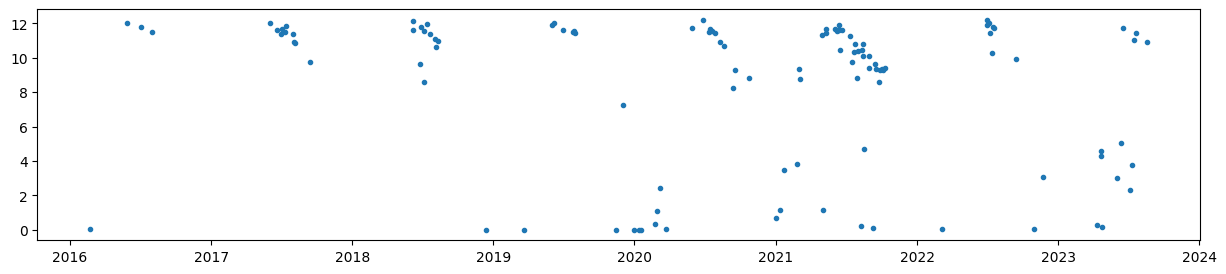

In [20]:
plt.figure(figsize=(15,3))
plt.plot(df_['datetime'],df_['enh_area1'],'.')
plt.show()

## Outlier Detection

In [21]:
minA = cls_df['enh_area1'].quantile(0.05)
aveA = cls_df['enh_area1'].quantile(0.5)
df = cls_df[(cls_df['cloud_cover']<1)&(cls_df['enh_area1']>minA)]

/tmp/job.462955/ipykernel_3305979/3642686503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days'] = (df['datetime'] - df['datetime'].iloc[0]).dt.days
/tmp/job.462955/ipykernel_3305979/3642686503.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoothed'] = smoothed[:, 1]


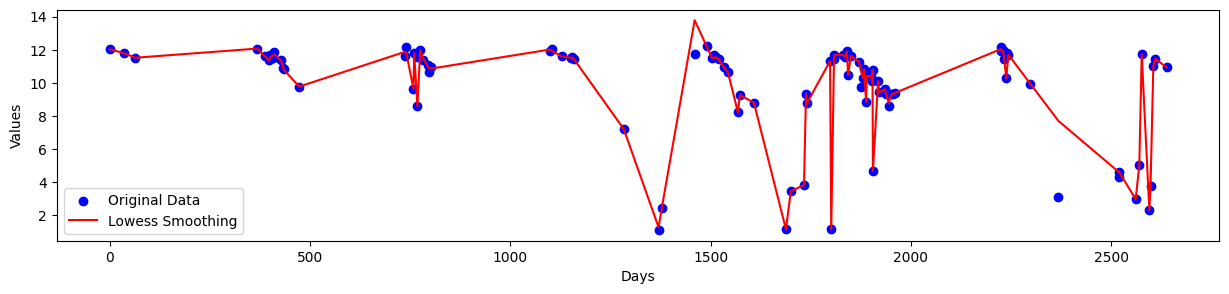

In [22]:
# Convert datetime to number of days since the first date
df['days'] = (df['datetime'] - df['datetime'].iloc[0]).dt.days

# Fit Lowess Smoothing
smoothed = lowess(df['enh_area1'], df['days'], frac=0.05)  # frac determines the smoothing parameter

# Extract smoothed values
df['smoothed'] = smoothed[:, 1]

# Plot the original data and the smoothed values
plt.figure(figsize=(15,3))
plt.scatter(df['days'], df['enh_area1'], color='blue', label='Original Data')
plt.plot(df['days'], df['smoothed'], color='red', label='Lowess Smoothing')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.show()

In [286]:
# Create a dictionary from df for faster lookup
smoothed_dict = dict(zip(df['days'], df['smoothed']))

In [287]:
def interpolate_smoothed_value(day):
    # If the day exists in df, return the smoothed value
    if day in smoothed_dict:
        return smoothed_dict[day]
    
    # Check if there are days before and after the current day in df
    before_days = df[df['days'] < day]
    after_days = df[df['days'] > day]
    
    # If no days before or after, return the nearest available smoothed value
    if before_days.empty:
        return after_days.iloc[0]['smoothed']
    if after_days.empty:
        return before_days.iloc[-1]['smoothed']
    
    # If there are days before and after, perform linear interpolation
    before_day = before_days.iloc[-1]
    after_day = after_days.iloc[0]
    
    fraction = (day - before_day['days']) / (after_day['days'] - before_day['days'])
    interpolated_value = before_day['smoothed'] + fraction * (after_day['smoothed'] - before_day['smoothed'])
    
    return interpolated_value

In [288]:
# Compute the days column for cls_df
cls_df['days'] = (cls_df['datetime'] - df['datetime'].iloc[0]).dt.days

# Compute the smoothed values for cls_df
cls_df['smoothed'] = cls_df['days'].apply(interpolate_smoothed_value)

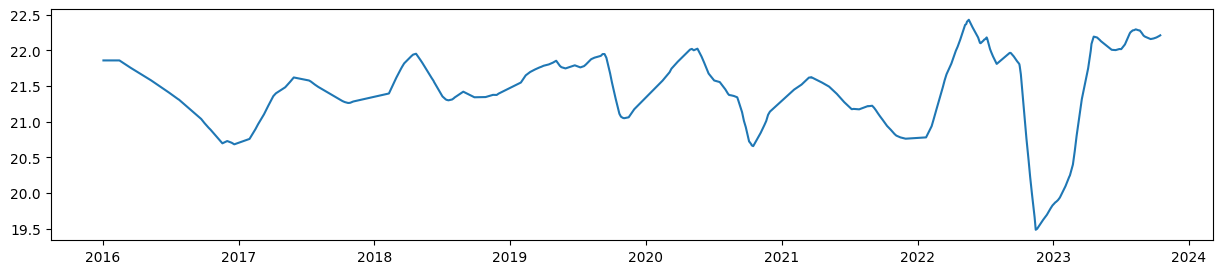

In [289]:
plt.figure(figsize=(15,3))
plt.plot(cls_df['datetime'], cls_df['smoothed'])
plt.show()

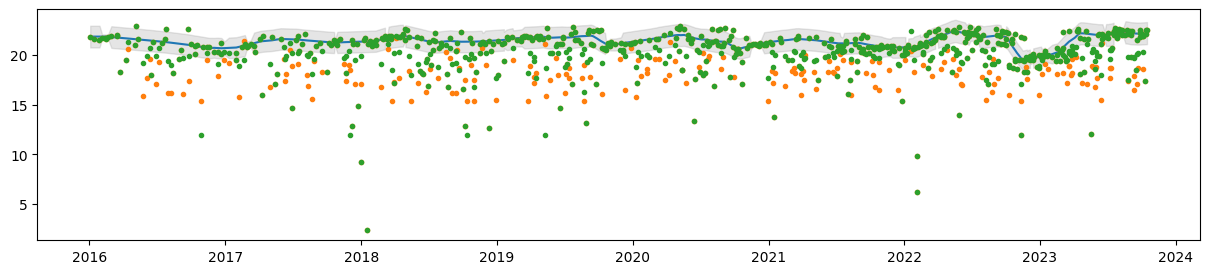

In [291]:
# Compute the rolling standard deviation with a window of 7 days
cls_df['rolling_std'] = cls_df['enh_area1'].rolling(window=7, center=True).std()

if aveA > 100:
    beta = 0.01
elif aveA > 10:
    beta = 0.05
elif aveA > 1:
    beta = 0.15
else:
    beta = 0.25

# Define the minimum and maximum constraints based on the 'smoothed' column
min_constraint = 0.01 * cls_df['smoothed']
max_constraint = beta * cls_df['smoothed']

# Constrain the 'rolling_std' values
cls_df['rolling_std'] = np.clip(cls_df['rolling_std'], min_constraint, max_constraint)

# If there are any NaN values in 'rolling_std', you can handle them as needed. 
# For example, to fill NaN values with the minimum constraint:
cls_df['rolling_std'].fillna(max_constraint, inplace=True)

# Display the result
plt.figure(figsize=(15,3))
plt.plot(cls_df['datetime'], cls_df['smoothed'])
plt.plot(cls_df['datetime'], cls_df['enh_area1'],'.')
plt.plot(cls_df['datetime'], cls_df['enh_area2'],'.')
plt.fill_between(cls_df['datetime'], cls_df['smoothed']-cls_df['rolling_std'], cls_df['smoothed']+cls_df['rolling_std'], color='gray', alpha=0.2)

In [292]:
for idx, row in cls_df.iterrows():
    if abs(row['enh_area1'] - row['smoothed'])<2*row['rolling_std']:
        cls_df.loc[idx,'lake_area'] = row['enh_area1']
    elif abs(row['enh_area2'] - row['smoothed'])<2*row['rolling_std']:
        cls_df.loc[idx,'lake_area'] = row['enh_area2']
    else:
        cls_df.loc[idx,'lake_area'] = np.nan

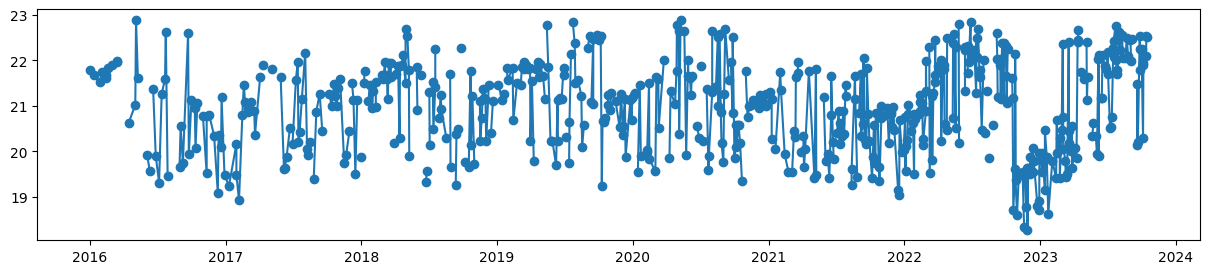

In [293]:
plt.figure(figsize=(15,3))
plt.plot(cls_df['datetime'],cls_df['lake_area'],'o-')
plt.show()

In [294]:
df = cls_df[cls_df['lake_area'].notnull()]
df

,date,terrain_area,enh_area1,enh_area2,threshold,elbow,cloud_cover,datetime,days,smoothed,rolling_std,lake_area
598,2016003,21.7764,21.7764,21.7764,NaN,NaN,1.297882,2016-01-03,-43,21.859703,1.092985,21.7764
408,2016012,21.6657,21.6657,21.6657,NaN,NaN,1.281846,2016-01-12,-34,21.859703,1.092985,21.6657
430,2016028,21.5091,21.5091,21.5091,NaN,NaN,1.236944,2016-01-28,-18,21.859703,1.092985,21.5091
537,2016035,21.7494,21.7494,21.7494,NaN,NaN,1.168736,2016-02-04,-11,21.859703,0.218597,21.7494
575,2016044,21.6765,21.6765,21.6765,NaN,NaN,1.014572,2016-02-13,-2,21.859703,0.218597,21.6765
...,...,...,...,...,...,...,...,...,...,...,...,...
549,2023279,21.9366,21.9366,21.9366,NaN,NaN,0.815929,2023-10-06,2790,22.182120,1.109106,21.9366
221,2023279,21.8934,21.8934,21.8934,NaN,NaN,0.677807,2023-10-06,2790,22.182120,1.109106,21.8934
677,2023286,22.0959,22.0959,22.0959,NaN,NaN,0.813582,2023-10-13,2797,22.200978,1.110049,22.0959
367,2023287,22.5297,22.5297,22.5297,NaN,NaN,0.837102,2023-10-14,2798,22.204319,1.110216,22.5297


/tmp/job.460805/ipykernel_1838643/994348936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days'] = (df['datetime'] - df['datetime'].iloc[0]).dt.days
/tmp/job.460805/ipykernel_1838643/994348936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoothed'] = smoothed[:, 1]


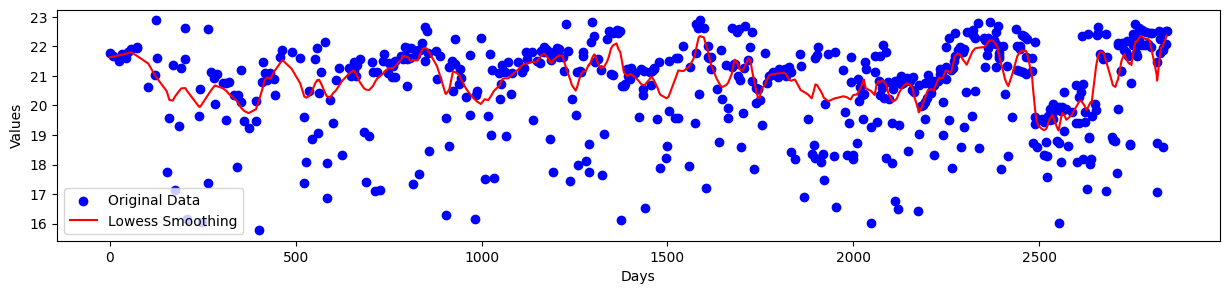

In [303]:
# Convert datetime to number of days since the first date
df['days'] = (df['datetime'] - df['datetime'].iloc[0]).dt.days

# Fit Lowess Smoothing
smoothed = lowess(df['lake_area'], df['days'], frac=0.02)  # frac determines the smoothing parameter

# Extract smoothed values
df['smoothed'] = smoothed[:, 1]

# Plot the original data and the smoothed values
plt.figure(figsize=(15,3))
plt.scatter(df['days'], df['enh_area1'], color='blue', label='Original Data')
plt.plot(df['days'], df['smoothed'], color='red', label='Lowess Smoothing')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.show()

/tmp/job.460805/ipykernel_1838643/46757033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['smoothed'] = smoothed[:, 1]


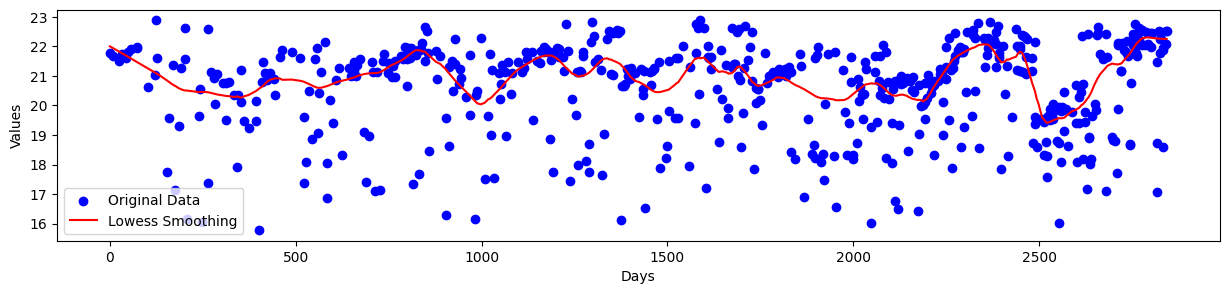

In [301]:
# Fit Lowess Smoothing
smoothed = lowess(df['smoothed'], df['days'], frac=0.05)  # frac determines the smoothing parameter

# Extract smoothed values
df['smoothed'] = smoothed[:, 1]

# Plot the original data and the smoothed values
plt.figure(figsize=(15,3))
plt.scatter(df['days'], df['enh_area1'], color='blue', label='Original Data')
plt.plot(df['days'], df['smoothed'], color='red', label='Lowess Smoothing')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.show()

/tmp/job.460805/ipykernel_1838643/3823564232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_std'] = df['lake_area'].rolling(window=30, center=True).std()
/tmp/job.460805/ipykernel_1838643/3823564232.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_std'] = np.clip(df['rolling_std'], min_constraint, max_constraint)
/tmp/job.460805/ipykernel_1838643/3823564232.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

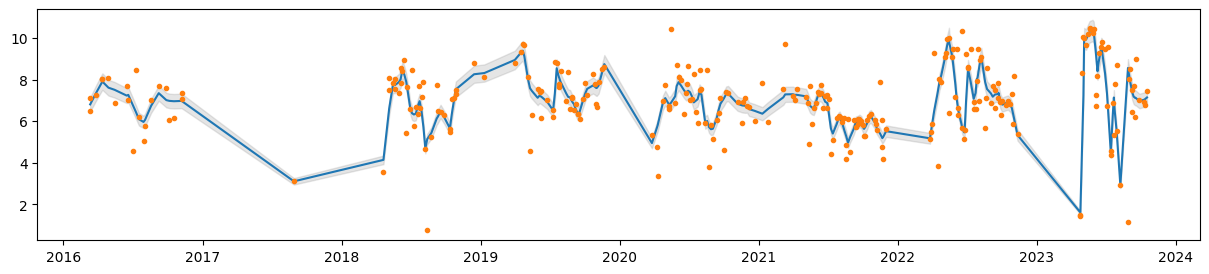

In [248]:
# Compute the rolling standard deviation with a window of 7 days
df['rolling_std'] = df['lake_area'].rolling(window=30, center=True).std()

if aveA > 100:
    beta = 0.01
elif aveA > 10:
    beta = 0.1
else:
    beta = 0.05

# Define the minimum and maximum constraints based on the 'smoothed' column
min_constraint = 0.01 * df['smoothed']
max_constraint = beta * df['smoothed']

# Constrain the 'rolling_std' values
df['rolling_std'] = np.clip(df['rolling_std'], min_constraint, max_constraint)

# If there are any NaN values in 'rolling_std', you can handle them as needed. 
# For example, to fill NaN values with the minimum constraint:
df['rolling_std'].fillna(max_constraint, inplace=True)

# Display the result
plt.figure(figsize=(15,3))
plt.plot(df['datetime'], df['smoothed'])
plt.plot(df['datetime'], df['lake_area'],'.')
plt.fill_between(df['datetime'], df['smoothed']-df['rolling_std'], df['smoothed']+df['rolling_std'], color='gray', alpha=0.2)

In [249]:
for idx, row in df.iterrows():
    if abs(row['enh_area1'] - row['smoothed'])<2*row['rolling_std']:
        df.loc[idx,'lake_area'] = row['enh_area1']
    elif abs(row['enh_area2'] - row['smoothed'])<2*row['rolling_std']:
        df.loc[idx,'lake_area'] = row['enh_area2']
    else:
        df.loc[idx,'lake_area'] = np.nan

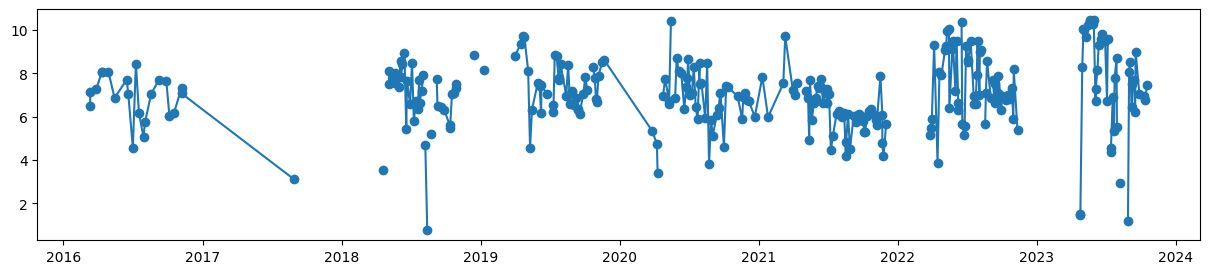

In [250]:
plt.figure(figsize=(15,3))
plt.plot(cls_df['datetime'],cls_df['lake_area'],'o-')
plt.show()

In [251]:
non_nan_count_A = df['lake_area'].notna().sum()

print(non_nan_count_A)
print(non_nan_count_A/df.shape[0])

218
0.759581881533101


In [225]:
df.to_csv(str(res_idx)+'_f.csv')

## Spline fitting

/scratch/user/anshulya/.conda/envs/hls_env/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


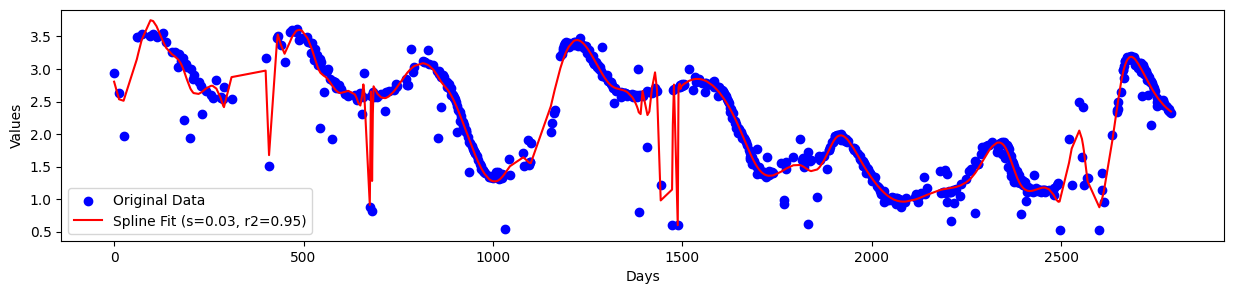

In [67]:
# Convert datetime to number of days since the first date
df['days'] = (df['datetime'] - df['datetime'].iloc[0]).dt.days

# Initialize variables
s = 0.1
max_r2 = -np.inf  # Start with a very low value
best_s = s
increment = 0.01
max_iterations = 100  # To prevent infinite loops, you can set a max number of iterations
iterations = 0

while iterations < max_iterations:
    try:
        # Fit a spline
        spline = UnivariateSpline(df['days'], df['enh_area1'], s=len(df['days']) * s)
        predicted = spline(df['days'])
        
        # Calculate r2 value
        r2 = r2_score(df['enh_area1'], predicted)
        
        # Update max_r2 and best_s if current r2 is greater
        if r2 > max_r2:
            max_r2 = r2
            best_s = s
    except ValueError:
        break  # If an error occurs, just skip and continue with the next iteration
    
    # Adjust smoothing factor
    s -= increment
    iterations += 1

# Use the best_s value to fit the spline for plotting
spline = UnivariateSpline(df['days'], df['enh_area1'], s=len(df['days']) * best_s)
predicted = spline(df['days'])

# Plot the original data and the spline
plt.figure(figsize=(15,3))
plt.scatter(df['days'], df['enh_area1'], color='blue', label='Original Data')
plt.plot(df['days'], predicted, color='red', label=f'Spline Fit (s={best_s:.2f}, r2={max_r2:.2f})')
plt.xlabel('Days')
plt.ylabel('Values')
plt.legend()
plt.show()

In [177]:
# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)

# Compute weekly mean and standard deviation
weekly_stats = df[['smoothed']].resample('W').agg(['median', 'std'])

df = df.reset_index()
weekly_stats = weekly_stats.reset_index()

In [178]:
weekly_stats

datetime  smoothed          
                  median       std
0   2016-01-31  2.572670  0.000000
1   2016-02-07       NaN       NaN
2   2016-02-14  2.625671       NaN
3   2016-02-21  2.674043       NaN
4   2016-02-28  2.701992       NaN
..         ...       ...       ...
394 2023-08-20  2.572174       NaN
395 2023-08-27  2.490766  0.009391
396 2023-09-03  2.450311       NaN
397 2023-09-10  2.383270  0.021436
398 2023-09-17  2.333222  0.019228

[399 rows x 3 columns]

In [179]:
for idx, row in weekly_stats.iterrows():
    # if np.isnan(weekly_stats.loc[idx,'enh_area1']['median']):
    #     weekly_stats.loc[idx,('enh_area1','median')] = spline((weekly_stats.loc[idx,'datetime'].values[0] - 
    #                                                      weekly_stats.iloc[0,0]).days)
    if np.isnan(weekly_stats.loc[idx,'smoothed']['std']):
        weekly_stats.loc[idx,('smoothed','std')] = max(weekly_stats.loc[idx,'smoothed']['median']*0.1,0.005)

In [180]:
weekly_stats

datetime  smoothed          
                  median       std
0   2016-01-31  2.572670  0.000000
1   2016-02-07       NaN       NaN
2   2016-02-14  2.625671  0.262567
3   2016-02-21  2.674043  0.267404
4   2016-02-28  2.701992  0.270199
..         ...       ...       ...
394 2023-08-20  2.572174  0.257217
395 2023-08-27  2.490766  0.009391
396 2023-09-03  2.450311  0.245031
397 2023-09-10  2.383270  0.021436
398 2023-09-17  2.333222  0.019228

[399 rows x 3 columns]

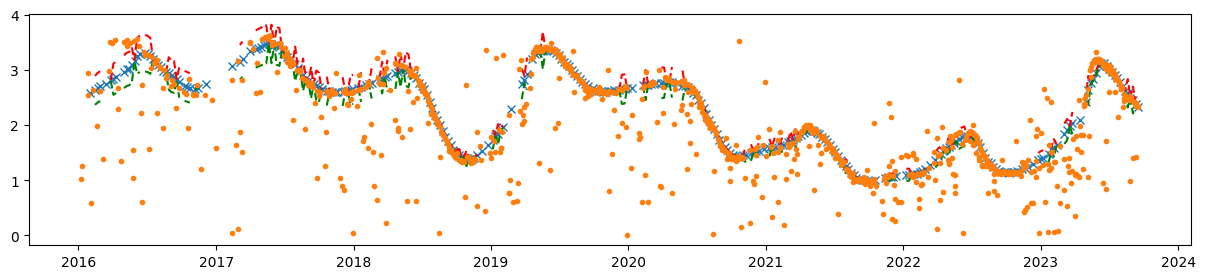

In [191]:
df_ = cls_df[cls_df['cloud_cover']<100]
plt.figure(figsize=(15,3))
plt.plot(weekly_stats['datetime'],weekly_stats['smoothed']['median'],'x')
plt.plot(weekly_stats['datetime'], weekly_stats['smoothed']['median'] + weekly_stats['smoothed']['std'], 'r', label='Upper Envelope', linestyle='--')
plt.plot(weekly_stats['datetime'], weekly_stats['smoothed']['median'] - weekly_stats['smoothed']['std'], 'g', label='Lower Envelope', linestyle='--')
plt.plot(df_['datetime'],df_['enh_area1'],'.')
plt.show()

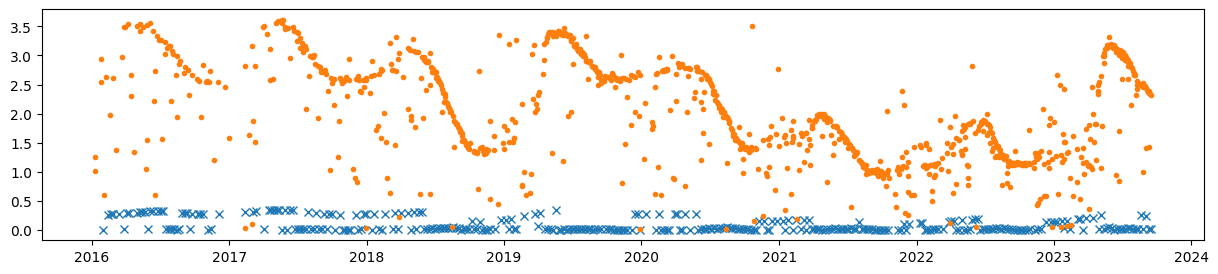

In [189]:
df_ = cls_df[cls_df['cloud_cover']<100]
plt.figure(figsize=(15,3))
plt.plot(weekly_stats['datetime'],weekly_stats['smoothed']['std'],'x')
plt.plot(df_['datetime'],df_['enh_area1'],'.')
plt.show()

In [182]:
df_ = cls_df[(cls_df['cloud_cover']<100)]
print(df_.shape)

(973, 8)


In [183]:
weekly_stats

datetime  smoothed          
                  median       std
0   2016-01-31  2.572670  0.000000
1   2016-02-07       NaN       NaN
2   2016-02-14  2.625671  0.262567
3   2016-02-21  2.674043  0.267404
4   2016-02-28  2.701992  0.270199
..         ...       ...       ...
394 2023-08-20  2.572174  0.257217
395 2023-08-27  2.490766  0.009391
396 2023-09-03  2.450311  0.245031
397 2023-09-10  2.383270  0.021436
398 2023-09-17  2.333222  0.019228

[399 rows x 3 columns]

In [184]:
for idx, row in df_.iterrows():
    specific_date = row['datetime']
    
    # Find the index of the row with the closest date
    closest_date_idx = abs(weekly_stats['datetime'] - specific_date).idxmin()
    

    # Retrieve the row with the closest date
    closest_date_row = weekly_stats.loc[closest_date_idx]

    if row['cloud_cover']<0 and row['enh_area1']>minA:
        df_.loc[idx,'lake_area'] = row['enh_area1']
    elif abs(row['enh_area1'] - closest_date_row[('smoothed','median')])<2*closest_date_row[('smoothed','std')]:
        df_.loc[idx,'lake_area'] = row['enh_area1']
    elif abs(row['enh_area2'] - closest_date_row[('smoothed','median')])<2*closest_date_row[('smoothed','std')]:
        df_.loc[idx,'lake_area'] = row['enh_area2']
    else:
        df_.loc[idx,'lake_area'] = np.nan

In [185]:
df_

,date,terrain_area,enh_area1,enh_area2,threshold,elbow,cloud_cover,datetime,lake_area
453,2016009,0.7416,1.0125,1.9764,95.0,84.0,7.949682,2016-01-09,NaN
714,2016010,0.0891,1.2474,1.8081,92.0,86.0,8.525875,2016-01-10,NaN
738,2016026,1.9287,2.5407,3.1824,87.0,56.0,3.060166,2016-01-26,NaN
163,2016026,2.8818,2.9349,3.1608,77.0,59.0,1.953665,2016-01-26,NaN
821,2016035,0.0324,0.5940,0.0396,95.0,98.0,18.702290,2016-02-04,NaN
...,...,...,...,...,...,...,...,...,...
827,2023253,2.3472,2.3472,2.3472,NaN,NaN,0.203147,2023-09-10,2.3472
451,2023254,2.3904,2.3904,2.3904,NaN,NaN,0.527317,2023-09-11,2.3904
872,2023254,0.9180,1.4166,2.2257,94.0,76.0,6.405602,2023-09-11,NaN
370,2023257,2.3400,2.3400,2.3400,NaN,NaN,0.280947,2023-09-14,2.3400


In [186]:
# df_[df_['lake_area']<200]

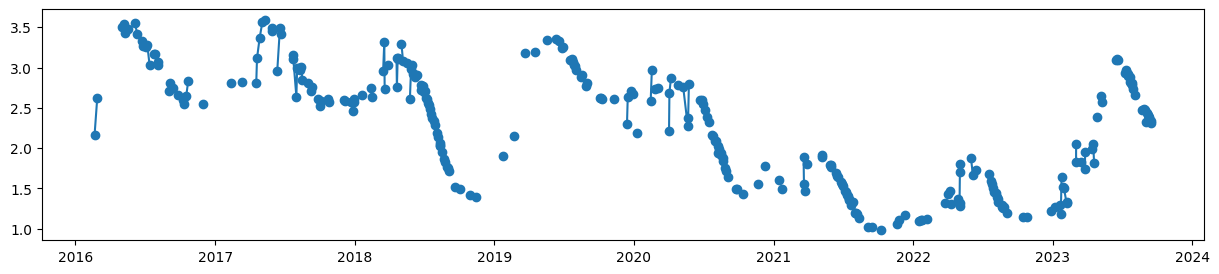

In [187]:
plt.figure(figsize=(15,3))
plt.plot(df_['datetime'],df_['lake_area'],'o-')

In [188]:
non_nan_count_A = df_['lake_area'].notna().sum()

print(non_nan_count_A)

290


In [116]:
df_.to_csv(str(res_idx)+'_f.csv')